## Demo pour la maquette

Ceci est un notebook de démo pour la simulation numérique de la maquette.

La maquette contient une couche en sable et une couche en bille. Des codes suivants vont simuler ces deux couches et faire sortir le diagramme de température en différentes profondeurs, étant donné les propriétés de chaque couche, la différence de charge variable, les conditions aux limites de température.

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [17]:
capteur_ZH = pd.read_csv("data/Point034/point034_T_measures.csv", sep = ',', header = 0, names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], usecols = [1, 2, 3, 4, 5], skiprows=1)
capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'], infer_datetime_format=True)
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15

n_t = len(capteur_ZH['dates'])
times = [datetime.fromtimestamp(1000*k) for k in range(n_t)]

T_vir = np.zeros((n_t,5))
T_vir[:,0] = np.arange(n_t)/n_t*2*np.cos(2*np.pi*1*3600) + 273 +12
# dont l'amplitude et la période seront déterminés pour que les signuax soient visibles
T_vir[:,1] = capteur_ZH[['temperature_10']].to_numpy().transpose() # à calculer et afficher
T_vir[:,2] = capteur_ZH[['temperature_20']].to_numpy().transpose() # à calculer et afficher
T_vir[:,3] = capteur_ZH[['temperature_30']].to_numpy().transpose() # à calculer et afficher
T_vir[:,4] = 273 + 12*np.ones(n_t) #température aquifère constante
T_measures = list(zip(capteur_ZH['dates'], T_vir))

temps = np.load("data/val_data.npy")
dH_measures = list(zip(times,list(zip(.1*np.cos(np.linspace(0,2*np.pi,28*24*3600)), T_vir[:,0]))))
#La différence de charge varie de 10cm à -10cm au cours de 2 semaines, ce qui est simulé par une fonction sinusoïdale de période de 28 jours.

In [18]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": dH_measures,
    "T_measures": T_measures,
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}

col = Column.from_dict(col_dict)

In [19]:
try:
    col.get_depths_solve()
except ComputationOrderException as e:
    print(e)
    
try:
    col.get_all_n()
except ComputationOrderException as e:
    print(e)

compute_solve_transi has to be computed before calling get_depths_solve.
compute_mcmc has to be computed before calling get_all_n.


In [20]:
layersList_1 = layersListCreator([("Couche en sable", 0.20, 3, 0.1, 2, 4e6), ("Couche en bille", 0.40, 3.5, 0.2, 2, 4e6)])

col.compute_solve_transi(layersList_1, 100)

--- Compute Solve Transi ---
Couche en sable : ends at 0.2 m. Parametres(moinslog10K=3, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche en bille : ends at 0.4 m. Parametres(moinslog10K=3.5, n=0.2, lambda_s=2, rhos_cs=4000000.0)
Done.


283.97775

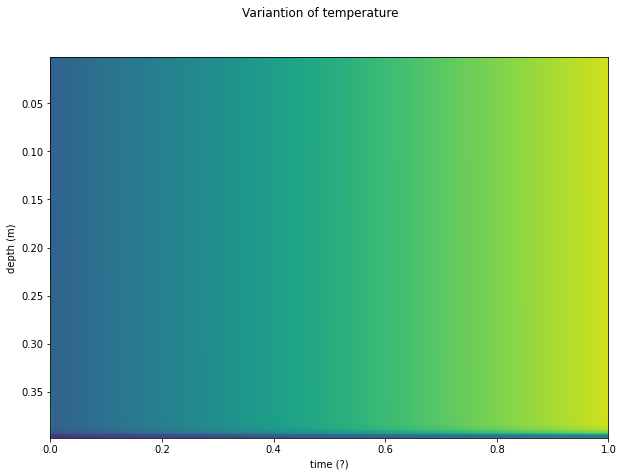

In [42]:
#Tout est stocké dans la class col pour ne pas avoir à le stocker hors de la class
fig, ax = plt.subplots(figsize=(10, 7), facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [0, 1, col.depths_solve[-1], col.depths_solve[0]], #TODO : trouver comment monter le datetime
)

fig.suptitle("Variantion of temperature")
ax.set_xlabel("time (?)")
ax.set_ylabel("depth (m)")
np.min(col.temps_solve)

Text(0, 0.5, 'depth (cm)??')

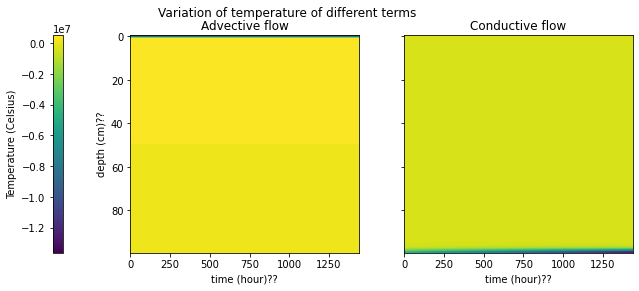

In [37]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,4), facecolor = 'w')

im = ax[0].imshow(col.advec_flows_solve, aspect='auto')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=1,location='left')
cbar.set_label('Temperature (Celsius)')

ax[1].imshow(col.conduc_flows_solve, aspect='auto')

ax[0].set_title('Advective flow')
ax[1].set_title('Conductive flow')

fig.suptitle("Variation of temperature of different terms")
for i in range(2):
    ax[i].set_xlabel("time (hour)??")

ax[0].set_ylabel("depth (cm)??")

Index 25 in z_array -> 0.10200000000000001
Index 50 in z_array -> 0.202
Index 75 in z_array -> 0.302


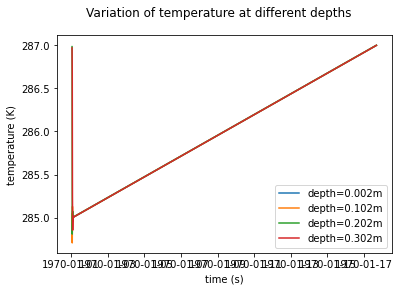

In [32]:
ind1 = 25
ind2 = 50
ind3 = 75
print(f"Index {ind1} in z_array -> {col.depths_solve[ind1]}")
print(f"Index {ind2} in z_array -> {col.depths_solve[ind2]}")
print(f"Index {ind3} in z_array -> {col.depths_solve[ind3]}")

#print(f"Temp at index {ind1} and t = 0 -> {col.temps_solve[0, ind1]:.3f}")
#print(f"Temp at {col.depths_solve[ind1]:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind1])[0]:.3f}")
#print("col.get_temps correct inaccuracy in z.")
#print(f"Temp at {col.depths_solve[ind]+1e-3:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind]+1e-4)[0]:.3f}")

fig, ax = plt.subplots(facecolor = 'w')
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[0]), label = f"depth={col.depths_solve[0]:.3f}m")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind1]), label = f"depth={col.depths_solve[ind1]:.3f}m")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind2]), label = f"depth={col.depths_solve[ind2]:.3f}m")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind3]), label = f"depth={col.depths_solve[ind3]:.3f}m")
fig.suptitle("Variation of temperature at different depths")
ax.set_xlabel("time (s)")
ax.set_ylabel("temperature (K)")
ax.legend()